In [26]:
from sklearn.datasets import fetch_20newsgroups
import pkg_resources
import vowpalwabbit as vw
import numpy as np
import pandas as pd
import regex as re
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
newsgroups = fetch_20newsgroups()
newsgroups['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [3]:
text = newsgroups["data"][0]
target = newsgroups["target_names"][newsgroups["target"][0]]

print("-----")
print(target)
print("-----")
print(text.strip())
print("----")

-----
rec.autos
-----
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----
----


In [4]:
def to_vw_format(document, label=None):
    return (
        str(label or "")
        + " |text "
        + " ".join(re.findall("\w{3,}", document.lower()))
        + "\n"
    )


to_vw_format(text, 1 if target == "rec.autos" else -1)

'1 |text from lerxst wam umd edu where thing subject what car this nntp posting host rac3 wam umd edu organization university maryland college park lines was wondering anyone out there could enlighten this car saw the other day was door sports car looked from the late 60s early 70s was called bricklin the doors were really small addition the front bumper was separate from the rest the body this all know anyone can tellme model name engine specs years production where this car made history whatever info you have this funky looking car please mail thanks brought you your neighborhood lerxst\n'

In [5]:
all_documents = newsgroups["data"]
all_targets = [
    1 if newsgroups["target_names"][target] == "rec.autos" else -1
    for target in newsgroups["target"]
]

In [6]:
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_documents, all_targets, random_state=7
)

with open(os.path.join("20news_train.vw"), "w") as vw_train_data:
    for text, target in zip(train_documents, train_labels):
        vw_train_data.write(to_vw_format(text, target))
with open(os.path.join("20news_test.vw"), "w") as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

In [7]:
!vw -d $'20news_train.vw' --loss_function hinge -f $20news_model.vw

final_regressor = news_model.vw
using no cache
Reading datafile = 20news_train.vw
num sources = 1
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
Enabled learners: gd, scorer-identity, count_label
Input label = SIMPLE
Output pred = SCALAR
average  since         example        example        current        current  current
loss     last          counter         weight          label        predict features
1.000000 1.000000            1            1.0        -1.0000         0.0000      157
0.911277 0.822554            2            2.0        -1.0000        -0.1774      159
0.605794 0.300311            4            4.0        -1.0000        -0.3994       92
0.419598 0.233402            8            8.0        -1.0000        -0.8167      129
0.314001 0.208404           16           16.0        -1.0000        -0.6509      108
0.196016 0.078030           32           32.0        -1.0000        -1.0000      115
0.183160 0.170304           64           64.0        -1.0000

In [8]:
!vw -i $20news_model.vw -t -d $'20news_test.vw' -p $20news_test_predictions.txt

only testing
predictions = news_test_predictions.txt
using no cache
Reading datafile = 20news_test.vw
num sources = 1
Num weight bits = 18
learning rate = 0.5
initial_t = 8485
power_t = 0.5
Enabled learners: gd, scorer-identity, count_label
Input label = SIMPLE
Output pred = SCALAR
average  since         example        example        current        current  current
loss     last          counter         weight          label        predict features
n.a.     n.a.                1            1.0        unknown         1.0000      349
n.a.     n.a.                2            2.0        unknown        -1.0000       50
n.a.     n.a.                4            4.0        unknown        -1.0000      251
n.a.     n.a.                8            8.0        unknown        -1.0000      237
n.a.     n.a.               16           16.0        unknown        -0.8977      106
n.a.     n.a.               32           32.0        unknown        -1.0000      964
n.a.     n.a.               64       

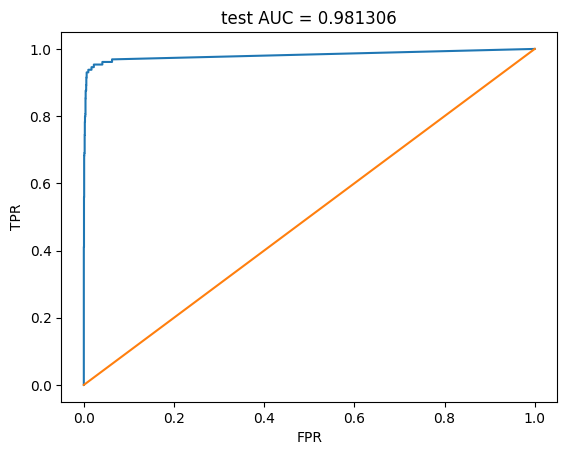

In [9]:
with open(os.path.join("news_test_predictions.txt")) as pred_file:
    test_prediction = [float(label) for label in pred_file.readlines()]

auc = roc_auc_score(test_labels, test_prediction)
roc_curve = roc_curve(test_labels, test_prediction)


plt.plot(roc_curve[0], roc_curve[1])
plt.plot([0, 1], [0, 1])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("test AUC = %f" % (auc))
plt.axis([-0.05, 1.05, -0.05, 1.05]);

In [12]:
all_documents = newsgroups["data"]
topic_encoder = LabelEncoder()
all_targets_mult = topic_encoder.fit_transform(newsgroups["target"]) + 1

In [13]:
train_documents, test_documents, train_labels_mult, test_labels_mult = train_test_split(
    all_documents, all_targets_mult, random_state=7
)

with open(os.path.join("20news_train_mult.vw"), "w") as vw_train_data:
    for text, target in zip(train_documents, train_labels_mult):
        vw_train_data.write(to_vw_format(text, target))
with open(os.path.join("20news_test_mult.vw"), "w") as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

In [19]:
!vw --oaa 20 $'20news_train_mult.vw' -f $'20news_model_mult.vw' --loss_function=hinge

final_regressor = 20news_model_mult.vw
using no cache
Reading datafile = 20news_train_mult.vw
num sources = 1
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
Enabled learners: gd, scorer-identity, oaa
Input label = MULTICLASS
Output pred = MULTICLASS
average  since         example        example        current        current  current
loss     last          counter         weight          label        predict features
1.000000 1.000000            1            1.0             15              1      157
1.000000 1.000000            2            2.0              2             15      159
1.000000 1.000000            4            4.0             15             10       92
1.000000 1.000000            8            8.0             16             15      129
1.000000 1.000000           16           16.0             13             12      108
[info] label 20 found -- labels are now considered 1-indexed.
0.937500 0.875000           32           32.0              2           

In [21]:
!vw -i $'20news_model_mult.vw' -t -d $'20news_test_mult.vw' -p $'20news_test_predictions_mult.txt'

only testing
predictions = 20news_test_predictions_mult.txt
using no cache
Reading datafile = 20news_test_mult.vw
num sources = 1
Num weight bits = 18
learning rate = 0.5
initial_t = 8485
power_t = 0.5
Enabled learners: gd, scorer-identity, oaa
Input label = MULTICLASS
Output pred = MULTICLASS
average  since         example        example        current        current  current
loss     last          counter         weight          label        predict features
n.a.     n.a.                1            1.0        unknown              8      349
n.a.     n.a.                2            2.0        unknown              6       50
n.a.     n.a.                4            4.0        unknown             18      251
n.a.     n.a.                8            8.0        unknown             18      237
n.a.     n.a.               16           16.0        unknown              4      106
n.a.     n.a.               32           32.0        unknown             15      964
n.a.     n.a.            

In [22]:
with open(
    os.path.join("20news_test_predictions_mult.txt")
) as pred_file:
    test_prediction_mult = [float(label) for label in pred_file.readlines()]

In [24]:
accuracy_score(test_labels_mult, test_prediction_mult)

0.8723930717568045

In [27]:
M = confusion_matrix(test_labels_mult, test_prediction_mult)
for i in np.where(M[0, :] > 0)[0][1:]:
    print(newsgroups["target_names"][i], M[0, i])

rec.autos 1
rec.sport.baseball 1
sci.med 1
soc.religion.christian 2
talk.religion.misc 6
